## Multi-layer neural network implemented in Python numpy for the Titanic classification problem

<img src='/titanic.jpg' width='700' height='300'>

### Approach 

This notebook follows three steps: 

1. Load datasets for training and development (evaluation)
2. Construct a model function with the helper functions defined in this repo 
3. Run the model first trying to optimize for training set accuracy (bias) and subsequently for development set accuracy (variance) 

### Rationale

The idea for this notebook is to implement a fully connected deep neural network entirely in numpy as a **training exercise.**  

### The model 

- Implements a **multilayer neural network** for the Titianic classification problem. Functions are mostly a generalizations of code introduced in the courses 1-3 of Andrew Ng's deep learning specialization (https://www.coursera.org/specializations/deep-learning)
- The model allows to choose an architecture of fully connected layers (i.e., number of layers and number of neurons per layer) and runs gradient descent returning a dictionary of trained parameters (W and b). The model supports He and Xavier parameter initialization, Adam gradient descent, as well as L2 and droput regularization  
- The model calls the following functions: 
    1. **Initialize parameters** (adjustable for Xavier and He initialization) -- initializes the layer parameters W and b and stores them in a dictionary
    2. **Initialize Adam** (Adaptive Moment Estimation) gradient descent -- initializes two dictionaries of the same shape as the parameters W and b to hold the momentum terms during the gradient descent. The first momentum term consists of the exponentially decaying average of past **squared** gradients (i.e., like RMSprop) and the second momentum term consists of an exponentially decaying average of past gradients (i.e., like momentum) 
    3. **Linear forward propagation for one layer** -- computes the linear term Z for a layer based on the activation of the previous layer and the parameters W and b 
    4. **Activation functions** -- encompasses functions to compute Sigmoid, tanh, ReLU, and leaky ReLU activations
    5. **Activation for one layer** integrating the linear forward function and the activation functions to compute the activation for one layer based on the activation of the previous layer, the parameters W and b, as well as the choice of activation function. Also implements the option for dropout to prevent overfitting 
    6. **Forward propagation** -- computes one forward pass through the network based on the feature vector input X. Adjustable for Sigmoid, tanh, ReLU and leaky ReLU activation for hidden layers
    7. **Compute cost"** -- computes the cross-entropy loss for each sample and averages it over all samples in the set/batch. Also implements L2 regularization (i.e., adding the sum of squared W parameters to the cost function to force smaller range of W values and thus reduce overfitting) 
    8. **Linear backward** -- for a single layer, computes the partial derivative terms dW, db and of the previous layer actiavtion dA_prev. dW is calculated with the L2 regularization term lambda. Also implements dropout (i.e., setting dW and db terms to zero for those neurons that were "dropped out" on the forward pass
    9. **Activation function derivatives** -- computes partial derivatives for Sigmoid, tanh, ReLU and leaky ReLU activation functions 
    10. **Linear activation backward** -- integrates the computation of the partial derivative of the cost function with respect to the activation in a given layer. Can handle a choice of Sigmoid, tanh, ReLU and leaky ReLU activation functions 
    11. **Backward propagation** -- Runs backward propagation through all layers 
    12. **Update parameters** -- update parameters W and b using Adam 
    13. **Predict labels** -- Predict labels based on input vector X and learned parameters W and b 
    14. **Calculate accuracy** -- Calculate accuracy of predictions against label vector (i.e., for trainign and dev set) 




- #### Model helper functions:
    - Titanic_data
    - helpers_np_model


Source of data: https://www.kaggle.com/c/titanic

In [1]:
# importing packages
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd

# importing helpers
from Titanic_data import titanic_preprosessing, split_train_dev
from helpers_np_model import *

%matplotlib inline

### Load data 

Link to functions being called: https://github.com/PhilSorgenfrei/ML_with_numpy/blob/master/Numpy_model/Titanic_data.ipynb

The function applies some pre-processing to the raw dataset and then splits it into a training and development set (applying an 80/20 ratio)

In [2]:
# load training data from csv file 
train_df = pd.read_csv("C:\\Users\\Philipp Sorgenfrei\\Desktop\\Deep learning\\Deep learning specialization\\" \
                         "99_data\\titanic\\train.csv")

# pre-process training data (see file "Titanic_data" for source code)
y, x = titanic_preprosessing(train_df)

# split training data into training and development set at an 80:20 ratio 
# (see file "Titanic_data" for source code)
train_split = 0.8
x_train, x_dev, y_train, y_dev = split_train_dev(train_split, x, y)

# check shapes of numpy vectors 
print("The input vector shape is: " + str(x_train.shape))
print("The label vector shape is: " + str(y_train.shape))

The input vector shape is: (45, 712)
The label vector shape is: (1, 712)


### Define model

Link to functions being called here: https://github.com/PhilSorgenfrei/ML_with_numpy/blob/master/Numpy_model/helpers_np_model.ipynb

#### Model inputs: 
- **x_train, y_train** -- training feature vector and training label vector to be used during gradient descent 
- **x_dev, y_dev** -- development feature vector and development label vector to estimate model accuracy 
- **layers_dims** -- Hyperparameter: list defining model architecture where first layer is determined by number of input features (x_train.shape[0]) while hidden layers can be freely chosen 
- **learning_rate** -- Hyperparameter: learning rate of gradient descent 
- **num_iterations** -- Hyperparameter: number of training iterations 
- **deep_activation** -- Hyperparameter: choice of activation function to be applied to hidden layers, e.g., "sigmoid", "tanh", "relu" or "leaky_relu" 
- **init_tuning** -- Hyperparameter: tunes initialization of parameters W and b. Set to init_tuning=0.5 for Xavier initalization and init_tuning=1 for He initualization
- **lambd** -- Hyperparameter: determines weight of L2 regularization term in cost function and when calculating gradients 
- **beta1 and beta2** -- Hyperparameter: exponential decay hyperparameter for the first and second moment estimates respectively (for Adaptive Moment Estimation -Adam- gradient descent) 
- **keep_prob** -- Hyperparameter: probability of NOT "dropping" a node in any hidden layer (to allow for droput regularization) 
- **print_cost, print_acc** -- set to True in order for the model to regularly print costs and display dev set accuracy at the end of training

In [3]:
def Titanic_model(x_train, y_train, x_dev, y_dev, layers_dims, learning_rate, 
                  num_iterations, deep_activation, init_tuning, lambd, beta1, beta2, keep_prob, 
                  print_cost=True, print_acc=True):
    
    costs = []
    devset_accuracy = {}                         
    
    # Parameters initialization
    parameters = initialize_parameters(layers_dims, init_tuning)
    
    # Adams trailing averages initialization 
    v, s = initialize_Adam(parameters)
    
    # Gradient descent loop
    for i in range(0, num_iterations):

        # Forward propagation
        AL, caches = L_model_forward(x_train, parameters, deep_activation, keep_prob)
        
        cost = compute_costs(AL, y_train, parameters, lambd)
        
        # Backward propagation.
        grads = L_model_backward(AL, y_train, caches, deep_activation, lambd, keep_prob)
                
        # Update parameters.     
        parameters, v, s = update_parameters_Adam(parameters, grads, v, s, i, 
                                                  learning_rate, beta1, beta2, 
                                                  epsilon = 1e-8)
        
        # Print the cost every 2000 training examples
        if print_cost and i % 2000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
        # store cost and calculate accuracy on devset 
        if i % 5 == 0:
            # store cost
            costs.append(cost)
            # calculate accuracy on devset
            predictions_devset = predict(parameters, x_dev, deep_activation)
            accuracy_devset = accuracy(predictions_devset, y_dev)
            devset_accuracy[i] = accuracy_devset
            
    # plot cost and devset accuracy  
    if print_acc: 
        # set plot parameters             
        plt.rcParams['figure.figsize'] = (11.0, 7.0) 
        plt.ylabel('cost, accuracy', fontsize='large')
        plt.xlabel('iterations (5x)', fontsize='large')
        plt.title("Cost and devset set accuracy over iterations", fontsize='xx-large')
        
        # feed cost and devset_accuracy as input to plot
        plt.plot(np.squeeze(costs)*100, label='cost')
        plt.plot(devset_accuracy.values(), "r", label='devset accuracy, in %')
        plt.legend(fontsize='large')
        
        plt.show()
        
    # print train and devset accuracy after completed trainin  
    predictions_train = predict(parameters, x_train, deep_activation)
    predictions_devset = predict(parameters, x_dev, deep_activation)
    accuracy_train = round(accuracy(predictions_train, y_train), 2)
    accuracy_devset = round(accuracy(predictions_devset, y_dev), 2)
    print("Training accuracy: " + str(accuracy_train)+"%")
    print("Devset accuracy: " + str(accuracy_devset)+"%")
    
    return parameters

### Run model with aim to minimize training error

Optimizing for training error, i.e., optimizing for minimal bias (hyperparamters chosen with trial and error) 

Cost after iteration 0: 0.930246
Cost after iteration 2000: 0.497808
Cost after iteration 4000: 0.390572
Cost after iteration 6000: 0.350096
Cost after iteration 8000: 0.306614
Cost after iteration 10000: 0.259594
Cost after iteration 12000: 0.224010
Cost after iteration 14000: 0.203667
Cost after iteration 16000: 0.192312
Cost after iteration 18000: 0.186363


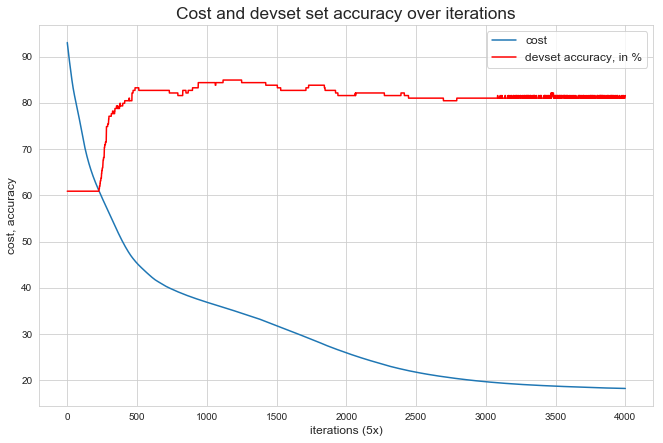

Training accuracy: 93.12%
Devset accuracy: 81.01%


In [6]:
parameters_train = Titanic_model(x_train, y_train, x_dev, y_dev, 
                                   layers_dims = [x_train.shape[0], 75, 15, 7, 1], 
                                   learning_rate=0.00003, 
                                   num_iterations = 20000, 
                                   deep_activation = "leaky_relu",
                                   init_tuning = 0.5, 
                                   lambd=0,
                                   beta1 = 0.9, 
                                   beta2 = 0.999,
                                   keep_prob=1,
                                   print_cost=True)

Running the model for 4000 steps, we see that training loss continuously improves and reaches 93% accuracy. The accuracy on the development set ultimately settles at 81%

### Run model with aim to minimize devset error

Optimizing for devset error, i.e., optimizing for minimal variance. To achieve this, we will use both **droput, and L2 regularization.** Dropout causes the loss function to randomly fluctuate (as seen on output graph below), however, it increases the development set accuracy from 81% to 85%. In other words, the model has learnt to better generalize from the training dataset. 

Cost after iteration 0: 0.962387
Cost after iteration 2000: 0.499393
Cost after iteration 4000: 0.441911
Cost after iteration 6000: 0.395767
Cost after iteration 8000: 0.386160


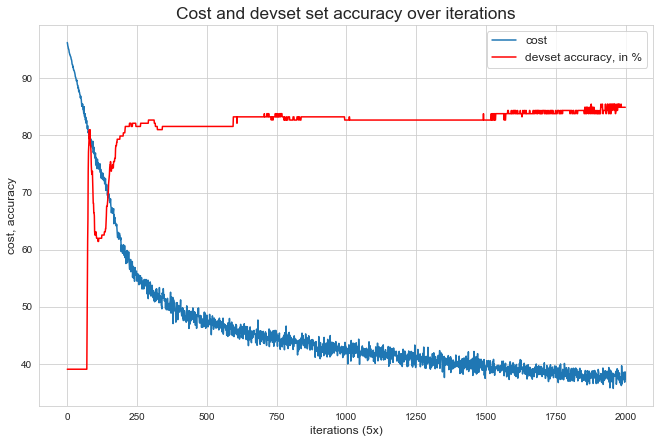

Training accuracy: 89.47%
Devset accuracy: 84.92%


In [8]:
parameters_dev = Titanic_model(x_train, y_train, x_dev, y_dev, 
                                   layers_dims = [x_train.shape[0], 75, 15, 7, 1], 
                                   learning_rate=0.0001, 
                                   num_iterations = 10000, 
                                   deep_activation = "leaky_relu",
                                   init_tuning = 0.5, 
                                   lambd=2.5,
                                   beta1 = 0.9, 
                                   beta2 = 0.999,
                                   keep_prob=0.90,
                                   print_cost=True)

### Predicting the labels in the test set
- Load test data
- Run prediction using the parameters learned in "min devset error" model 
- Save predictions in csv file

In [15]:
# load test data from csv file 
test_df = pd.read_csv("C:\\Users\\Philipp Sorgenfrei\\Desktop\\Deep learning\\Deep learning specialization\\" \
                         "99_data\\titanic\\test.csv")

# pre-process training data (see file "Titanic_data" for source code)
_, x_test = titanic_preprosessing(test_df)

# convert x_test to numpy array 
x_test = np.array(x_test)
# transpose x_test
x_test = np.transpose(x_test)

print("The input vector shape is: " + str(x_test.shape))

The input vector shape is: (45, 418)


In [20]:
# Predict with test data 
titanic_predictions = predict(parameters_dev, x_test, "leaky_relu")
titanic_predictions = titanic_predictions.flatten()

print(titanic_predictions)

[0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1
 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0
 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1
 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0
 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1
 1 0 1 0 1 1 1 1 0 1 0]


In [22]:
# convert predictions back into pandas table
titanic_predictions = np.transpose(titanic_predictions) 
pd_predictions = pd.DataFrame({'Survived':titanic_predictions}).astype(int)

# merge predictions with ID's again 
result_np_model = pd.concat([test_df['PassengerId'], pd_predictions], axis=1)

# write to csv 
path = "C:\\Users\\Philipp Sorgenfrei\\Desktop\\Documents Sync\\Box Sync\\" \
        "99_Machine learning\\Models\\Titanic\\00_Data\\result_np_model.csv"
result_np_model.to_csv(path, encoding='utf-8', index=False)